<h1><center>Bayesian Computation project, Spring 2019</center></h1>
<center>Charles Dufour, Sciper: 257587</center>


Take a look at the README.md to install all the needed libraries

In [1]:
#to make life easier
%load_ext autoreload
%autoreload 2

In [2]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings

import plotly.offline as py
py.init_notebook_mode(connected=False)

<body>
  <p style="color:red";>Due to a scipy latest update, may have to run twice the cell below</p>
</body>


[See issue on the Github](https://github.com/HIPS/autograd/issues/501) for a quick fix

In [3]:
from src.models import Model, Prior, Conditional_model
from src.sampling import Metropolis_Hastings as MH
from src.helpers import samples_exploration,big_plot,reset_plot, compare_samples_MH,visualisation
from src.optimization import gradient_descent as GD
import src.approximation.Laplace as Laplace

In [4]:
import src.maths.func_stats as fstats

# Load the data

In [5]:
df = pd.read_csv("data/wages.dat", 
                 sep="\s+")
y_not_normalized = df.LNWAGE.values.copy()

#normalization of continuous variables
df.LNWAGE = (df.LNWAGE - np.mean(df.LNWAGE.values))/np.std(df.LNWAGE.values)
df.ED =(df.ED - np.mean(df.ED.values))/np.std(df.ED.values)
df.EX =(df.EX - np.mean(df.EX.values))/np.std(df.EX.values)

#dropping correlated variables
df = df.drop(columns = ["EXSQ","AGE"], axis = 1)


#building predictors and response matrices
predictors_name = np.array(['ED', 'SOUTH', 'NONWH', 'HISP', 'FE', 'MARR', 'MARRFE', 'EX',
        'UNION', 'MANUF', 'CONSTR', 'MANAG', 'SALES', 'CLER',
        'SERV', 'PROF'])
predictors = df[predictors_name]
y = df.LNWAGE.values
X = predictors.values

#splitting train and test
# X,X_test are the covariates
# Y,Y_test are the normalized response
# y,y_test are the original reponse
X, X_test, Y, Y_test,  y, y_test = train_test_split(X, y, y_not_normalized, test_size=0.2, random_state=42)

# Exploratory analysis

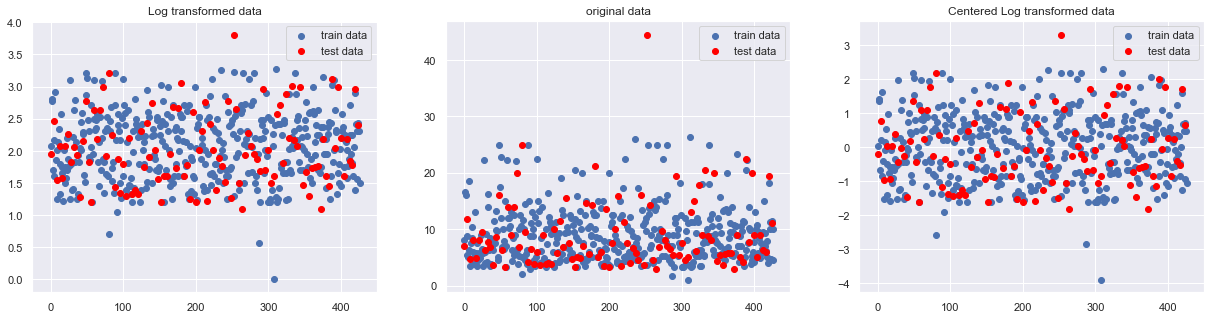

In [6]:
big_plot(21,5)
plt.subplot(132)
plt.scatter(np.arange(len(y)), np.exp(y), label = "train data")
plt.scatter(4*np.arange(len(y_test)), np.exp(y_test), label = "test data", color = "red")
plt.title("original data")
plt.legend()
plt.subplot(131)
plt.scatter(np.arange(len(y)), y, label = "train data")
plt.scatter(4*np.arange(len(y_test)), y_test, label = "test data", color = "red")
plt.title("Log transformed data")
plt.legend()
plt.subplot(133)
plt.scatter(np.arange(len(Y)), Y, label = "train data")
plt.scatter(4*np.arange(len(Y_test)), Y_test, label = "test data", color = "red")
plt.title("Centered Log transformed data")
plt.legend()
plt.show()

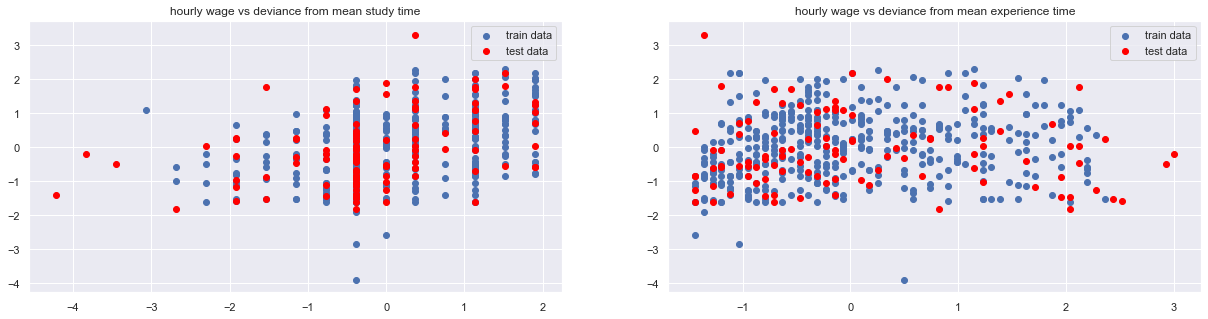

In [7]:
plt.subplot(121)
plt.scatter(X[:,0],Y,label = "train data")
plt.scatter(X_test[:,0],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean study time")
plt.subplot(122)
plt.scatter(X[:,7],Y, label = "train data")
plt.scatter(X_test[:,7],Y_test, label = "test data", color = "red")
plt.legend()
plt.title("hourly wage vs deviance from mean experience time")
plt.savefig("results/regressors.png",dpi = 300, bbox_inches = "tight")
plt.show()

# Create the models

`model_gausian`:

- Conditional model:
$$ Y = X\beta + \epsilon$$
$$\varepsilon_i \sim \mathcal{N}(0,\sigma^2)$$

- Priors:
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$
$$\sigma \sim exp(\lambda) \quad \lambda = 2 $$


`model_student`:
    
- conditional model:
$$ Y = X\beta + \epsilon$$


$$\varepsilon_i \sim \text{ Student of degree d }$$


- priors
$$\beta \sim \mathcal{N}(\vec{0},3^2I_d)$$


$$\text{ d } \sim \Gamma(2,4) $$    

In [8]:
model_gaussian = Model.Model(Prior.Gaussian_exp_prior,Conditional_model.Gaussian, Prior = [0,3,2], data = X, response = Y, additional_param = 1)
model_student = Model.Model(Prior.Gaussian_gamma_prior, Conditional_model.Student, Prior = [0,3,2,1/4], data = X, response = Y, additional_param = 1)

## Obtaining estimates of the parameters

## using Laplace approximation with different optimization methods

#### using vanilla gradient descent

Update step:
   $$ \theta_{n+1} = \theta_n - \eta\nabla f(\theta_n)$$

In [9]:
Laplace.laplace_approx(model_gaussian,method =  GD.vanilla_gd)

Progress : [====================] 100% Done...
 early convergence at 2644 iterations  duration: 0:00:04


In [10]:
Laplace.laplace_approx(model_student,method =  GD.vanilla_gd)

Progress : [====================] 100% Done...
   duration: 0:00:18


#### using line search

Update step:
   $$ \theta_{n+1} = \theta_n - \eta\nabla f(\theta_n)$$
additional condition: accept if 
$$f(\theta_{n+1})< f(\theta_n) -\eta\epsilon||\nabla_\theta f(\theta_n)||_2^2$$

In [11]:
Laplace.laplace_approx(model_gaussian,method =  GD.line_search_gd,name_method="line search")

Progress : [====================] 100% Done...
 early convergence at 3315 iterations  duration: 0:00:07


In [12]:
Laplace.laplace_approx(model_student,method =  GD.line_search_gd,name_method="line search")

Progress : [====================] 100% Done...
   duration: 0:00:20


#### using Wolfe condition to adpat the step size

Check the Wolfe condition and adapt the step size accordingly: $p_k = \nabla f(x_k)$,   $ \quad 0<c_1<c_2<1$

if $f(x_k + \alpha_kp_k) \leq f(x_k) + c_1\alpha_kp_k^T\nabla f(x_k)$  then reduce step size $\alpha_k$

if $-p_k^T\nabla f(x_k+\alpha_kp_k) \leq -c_2p_k^T\nabla f(x_k)$ then increase step size 

else accept update

In [13]:
Laplace.laplace_approx(model_gaussian,method =  GD.Wolfe_cond_gd,name_method="Wolfe conditions")

Progress : [====================] 100% Done...
   duration: 0:00:32


In [14]:
Laplace.laplace_approx(model_student,method =  GD.Wolfe_cond_gd,name_method="Wolfe conditions")

Progress : [====================] 100% Done...
   duration: 0:00:45


### Using stochastic gradient descent

In [15]:
Laplace.laplace_approx(model_gaussian,method =  GD.stochastic_gd,name_method="SGD")

Progress : [====================] 100% Done...
 early convergence at 3824 iterations  duration: 0:00:07


In [16]:
Laplace.laplace_approx(model_student,method =  GD.stochastic_gd,name_method="SGD")

Progress : [====================] 100% Done...
 early convergence at 6524 iterations  duration: 0:00:14


## Using Metropolis Hastings

Default burn-in period: $10\%$ of the run

#### with gaussian random walk

Progress : [====================] 100% Done...
  Acceptance rate : 16.1%  (advised values between 10% and 50%)
  duration: 0:00:18
iterations


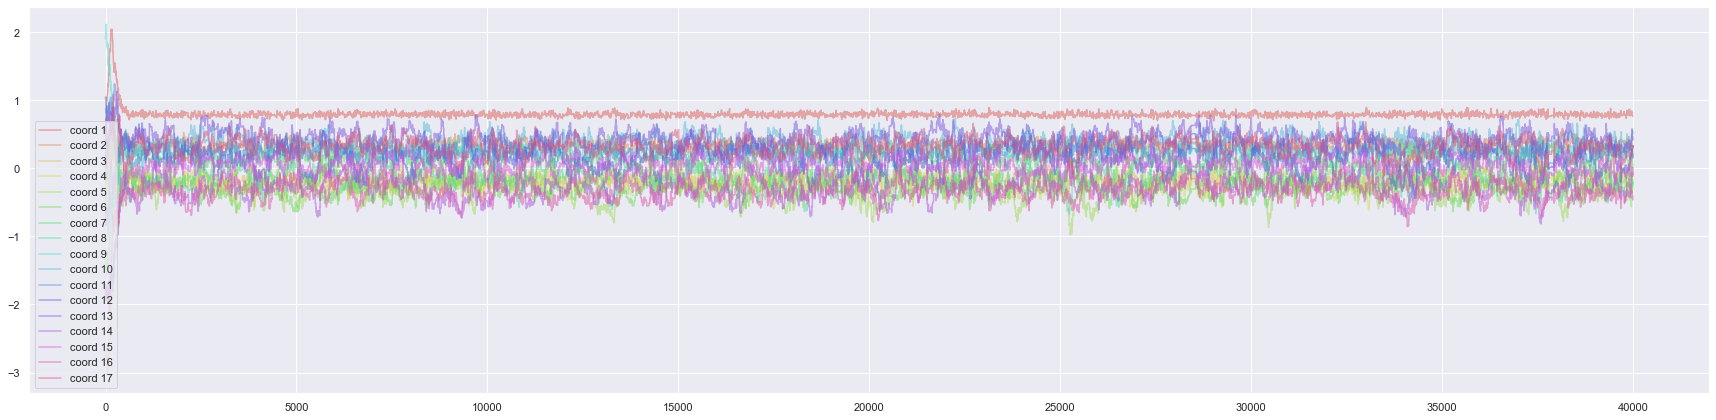

In [17]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_gaussian.size)
    initial[0]=0.5
    step_size = 0.05*np.ones(model_gaussian.size)
    step_size[0]=0.035
    samples_gaussian_rw = MH.random_walk_MH(model_gaussian, max_iter = 40000, verbose = True, step_size = step_size, initial = initial, RETURN= True)
    samples_exploration(samples_gaussian_rw,correlation=False,distribution=False)

Progress : [====================] 100% Done...
  Acceptance rate : 40.4%  (advised values between 10% and 50%)
  duration: 0:00:21
iterations


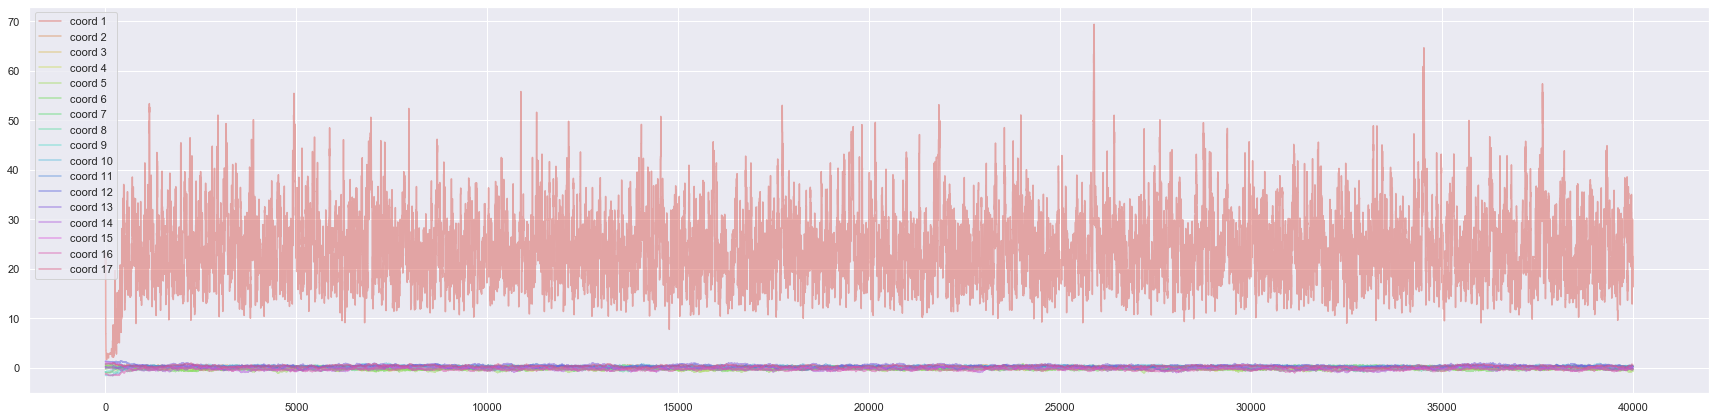

In [18]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_student.size)
    initial[0]= 20
    step_size = np.ones_like(initial)*0.035
    step_size[0] = 5
    samples_student_rw = MH.random_walk_MH(model_student, max_iter = 40000, verbose = True, step_size = step_size, initial = initial,RETURN= True)
    samples_exploration(samples_student_rw,correlation=False,distribution=False)

#### with Langevin correction

Progress : [====================] 100% Done...
  Acceptance rate : 31.3%                 (advised values between 10% and 50%)
  duration: 0:02:26
iterations


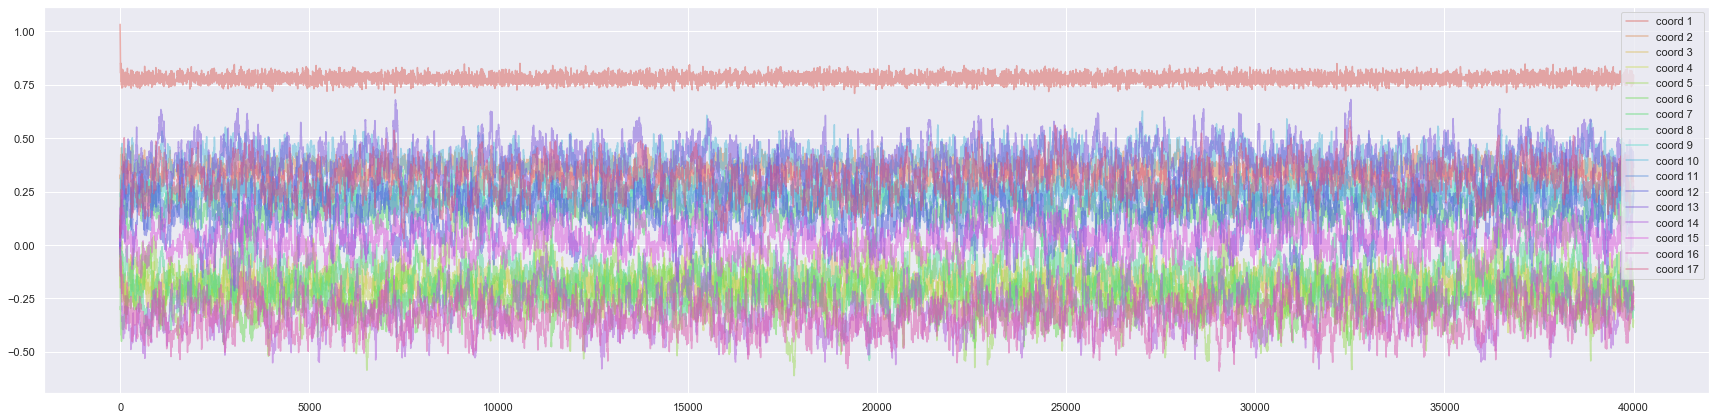

In [19]:
with warnings.catch_warnings(record=True):
    initial = np.zeros(model_gaussian.size)
    initial[0]=1
    samples_gaussian_langevin = MH.Langevin_MH(model_gaussian, max_iter = 40000, initial = initial,verbose = True, tau = 4*1e-4,RETURN=True)
    samples_exploration(samples_gaussian_langevin,correlation=False,distribution=False)

Progress : [====================] 100% Done...
  Acceptance rate : 25.8%                 (advised values between 10% and 50%)
  duration: 0:03:17
iterations


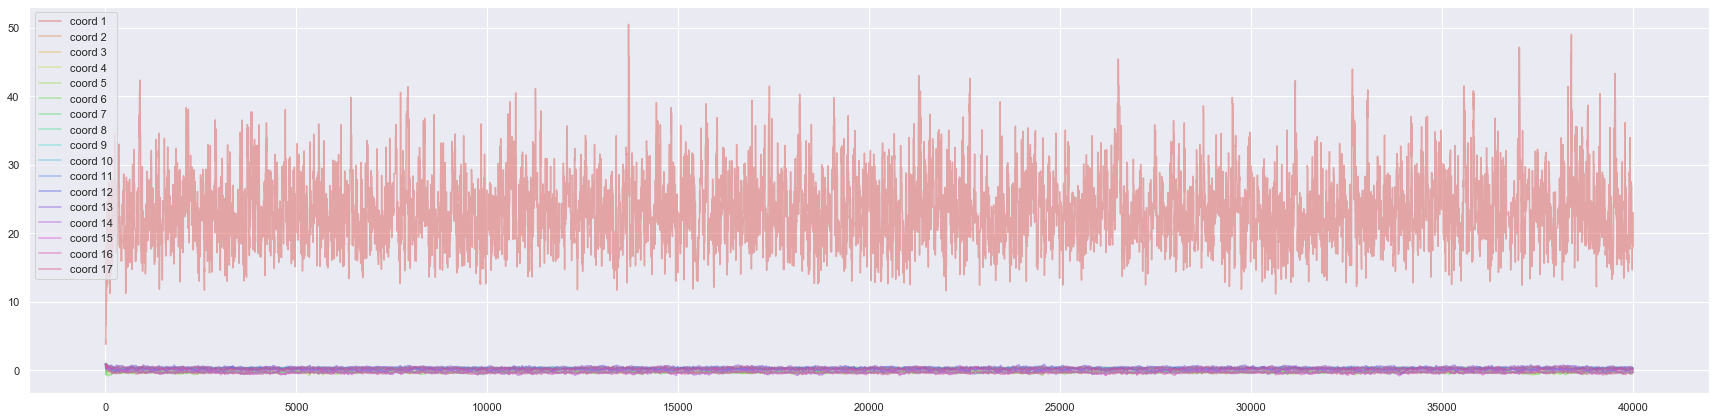

In [20]:
with warnings.catch_warnings(record=True):
    initial = np.ones(model_student.size)
    initial[0]=12
    step_size = np.ones(model_student.size)
    step_size[0] = 100
    samples_student_langevin = MH.Langevin_MH(model_student, max_iter = 40000, initial = initial, tau = 1e-3, RETURN=True,step_size = step_size)
    samples_exploration(samples_student_langevin,correlation=False, distribution = False)

#### Using Metropolis Hastings within gibbs

This is done to see if there is any gain in computational time

default batch is 5
Progress : [====================] 100% Done...
  Acceptance rate : 49.9%  (advised values between 10% and 50%)
  duration: 0:00:20
iterations


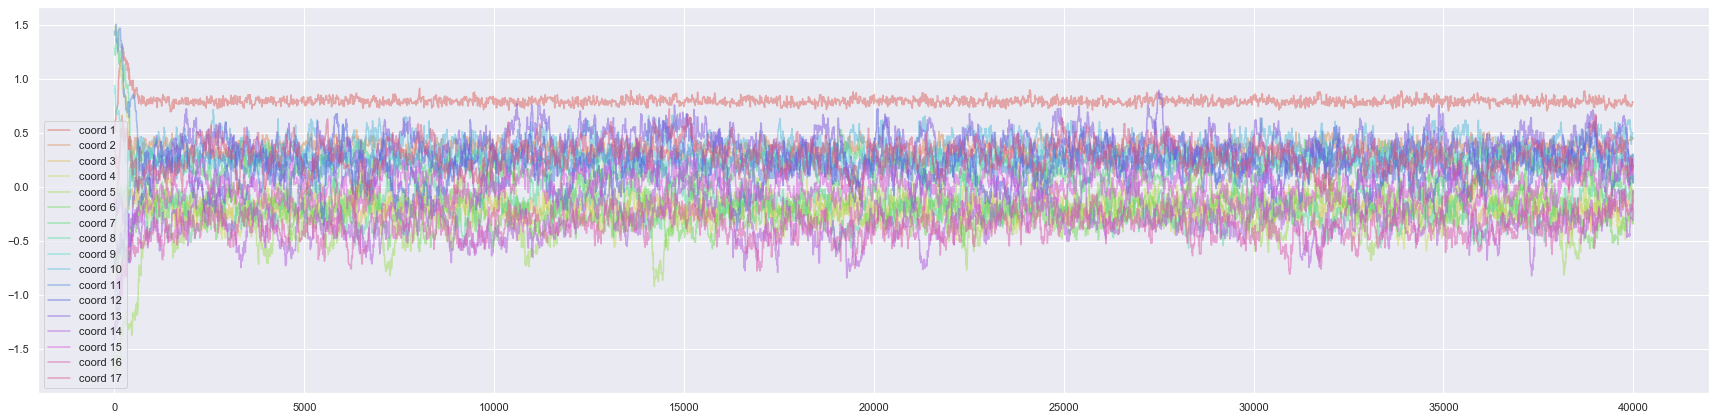

In [21]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_gaussian.size)
    initial[0]=0.5
    step_size = 0.05*np.ones(model_gaussian.size)
    step_size[0]=0.035
    samples_gaussian_gibbs = MH.MH_whithin_Gibbs(model_gaussian, max_iter = 40000, verbose = True, step_size = step_size, initial = initial, RETURN= True)
    samples_exploration(samples_gaussian_gibbs,correlation=False,distribution=False)

default batch is 5
Progress : [====================] 100% Done...
  Acceptance rate : 60.1%  (advised values between 10% and 50%)
  duration: 0:00:20
iterations


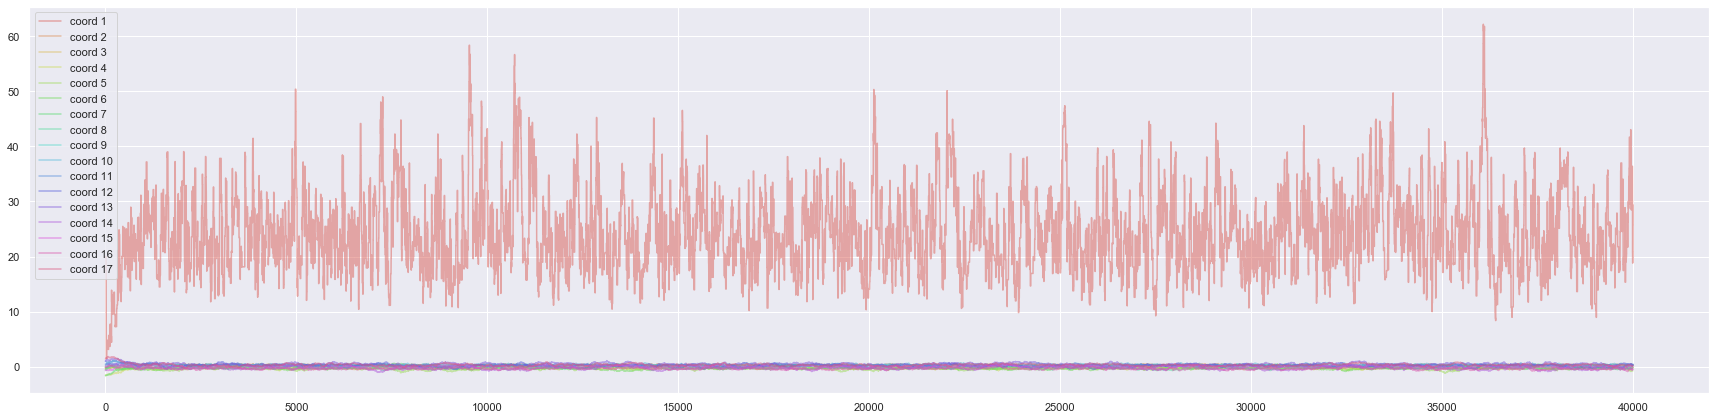

In [22]:
with warnings.catch_warnings(record=True):
    initial = np.random.randn(model_student.size)
    initial[0]= 20
    step_size = np.ones_like(initial)*0.05
    step_size[0] = 5
    samples_student_gibbs = MH.MH_whithin_Gibbs(model_student, max_iter = 40000, verbose = True, step_size = step_size, initial = initial,RETURN= True)
    samples_exploration(samples_student_gibbs,correlation=False,distribution=False)

### extraction of the estimates from the models

we use point estimates, precisely the mean of the distribution

In [23]:
r_gaussian = model_gaussian()
r_gaussian.T

error         ED     SOUTH     NONWH  \
Laplace with vanilla gd        0.773618  0.352062 -0.185671 -0.204009   
Laplace with line search       0.773617  0.351360 -0.185635 -0.205067   
Laplace with Wolfe conditions  0.793546  0.335745 -0.257839 -0.181027   
Laplace with SGD               0.777839  0.356278 -0.240482 -0.183010   
MH_vanilla                     0.791265  0.348166 -0.181393 -0.206648   
MH_Langevin                    0.780404  0.349985 -0.190663 -0.201357   
MH_Gibbs_mean                  0.791724  0.355378 -0.193967 -0.202940   

                                   HISP        FE      MARR    MARRFE  \
Laplace with vanilla gd       -0.210731 -0.236685  0.171597 -0.164767   
Laplace with line search      -0.213573 -0.241617  0.168226 -0.159564   
Laplace with Wolfe conditions  0.234199 -0.519991 -0.062918  0.093940   
Laplace with SGD               0.082469 -0.361732  0.083873 -0.098415   
MH_vanilla                    -0.257483 -0.270731  0.149547 -0.127659   
MH_Langevin                   -0.205172 -0.239083  0.171455 -0.163821   
MH_Gibbs_mean                 -0.175482 -0.220892  0.184909 -0.176986   

                                     EX     UNION     MANUF    CONSTR  \
Laplace with vanilla gd        0.258315  0.385157  0.212022  0.140837   
Laplace with line search       0.258249  0.385921  0.213565  0.142923   
Laplace with Wolfe conditions  0.272369  0.393092  0.336011  0.533428   
Laplace with SGD               0.280854  0.328401  0.275271  0.404067   
MH_vanilla                     0.256758  0.396324  0.224052  0.147042   
MH_Langevin                    0.258107  0.388295  0.208787  0.129733   
MH_Gibbs_mean                  0.258967  0.380286  0.205189  0.170334   

                                  MANAG     SALES      CLER      SERV  \
Laplace with vanilla gd        0.391442 -0.299647  0.024050 -0.346706   
Laplace with line search       0.395702 -0.295396  0.027576 -0.343354   
Laplace with Wolfe conditions  0.614766  0.174680  0.260062 -0.099339   
Laplace with SGD               0.440448 -0.010068  0.151933 -0.184340   
MH_vanilla                     0.419067 -0.279026  0.043254 -0.324819   
MH_Langevin                    0.397927 -0.296210  0.027031 -0.344515   
MH_Gibbs_mean                  0.380800 -0.308829  0.007231 -0.358255   

                                   PROF  
Laplace with vanilla gd        0.295447  
Laplace with line search       0.299723  
Laplace with Wolfe conditions  0.533979  
Laplace with SGD               0.403935  
MH_vanilla                     0.318405  
MH_Langevin                    0.298616  
MH_Gibbs_mean                  0.279564

In [24]:
r_student = model_student()
r_student.T

error         ED     SOUTH     NONWH  \
Laplace with vanilla gd         6.710007  0.339478 -0.204349 -0.240585   
Laplace with line search        6.717288  0.339489 -0.204342 -0.240539   
Laplace with Wolfe conditions  10.823977  0.339917 -0.201215 -0.229065   
Laplace with SGD                3.327308  0.346327 -0.261599 -0.234212   
MH_vanilla                     24.127511  0.339703 -0.189252 -0.220888   
MH_Langevin                    23.338462  0.344107 -0.195748 -0.212773   
MH_Gibbs_mean                  24.345602  0.334345 -0.202914 -0.225883   

                                   HISP        FE      MARR    MARRFE  \
Laplace with vanilla gd       -0.297076 -0.265108  0.207206 -0.187973   
Laplace with line search      -0.296992 -0.265012  0.207237 -0.188040   
Laplace with Wolfe conditions -0.276358 -0.257497  0.198861 -0.183202   
Laplace with SGD               0.080463 -0.477299  0.061727  0.008058   
MH_vanilla                    -0.271828 -0.240735  0.187758 -0.179021   
MH_Langevin                   -0.233322 -0.239880  0.193320 -0.183257   
MH_Gibbs_mean                 -0.216208 -0.264388  0.175305 -0.162291   

                                     EX     UNION     MANUF    CONSTR  \
Laplace with vanilla gd        0.264389  0.365789  0.205177  0.122438   
Laplace with line search       0.264385  0.365784  0.205155  0.122408   
Laplace with Wolfe conditions  0.262451  0.369417  0.205380  0.125425   
Laplace with SGD               0.269310  0.365836  0.280607  0.424520   
MH_vanilla                     0.259839  0.389392  0.206972  0.129288   
MH_Langevin                    0.260638  0.373771  0.202682  0.119818   
MH_Gibbs_mean                  0.261020  0.380978  0.207350  0.128110   

                                  MANAG     SALES      CLER      SERV  \
Laplace with vanilla gd        0.503425 -0.280596  0.059475 -0.359553   
Laplace with line search       0.503313 -0.280679  0.059397 -0.359594   
Laplace with Wolfe conditions  0.483618 -0.286252  0.050555 -0.355084   
Laplace with SGD               0.628900  0.058629  0.208350 -0.196587   
MH_vanilla                     0.453019 -0.293403  0.026222 -0.379346   
MH_Langevin                    0.441406 -0.305061  0.033633 -0.357026   
MH_Gibbs_mean                  0.474015 -0.276593  0.058354 -0.339560   

                                   PROF  
Laplace with vanilla gd        0.312958  
Laplace with line search       0.312888  
Laplace with Wolfe conditions  0.311113  
Laplace with SGD               0.430988  
MH_vanilla                     0.310204  
MH_Langevin                    0.299824  
MH_Gibbs_mean                  0.334003

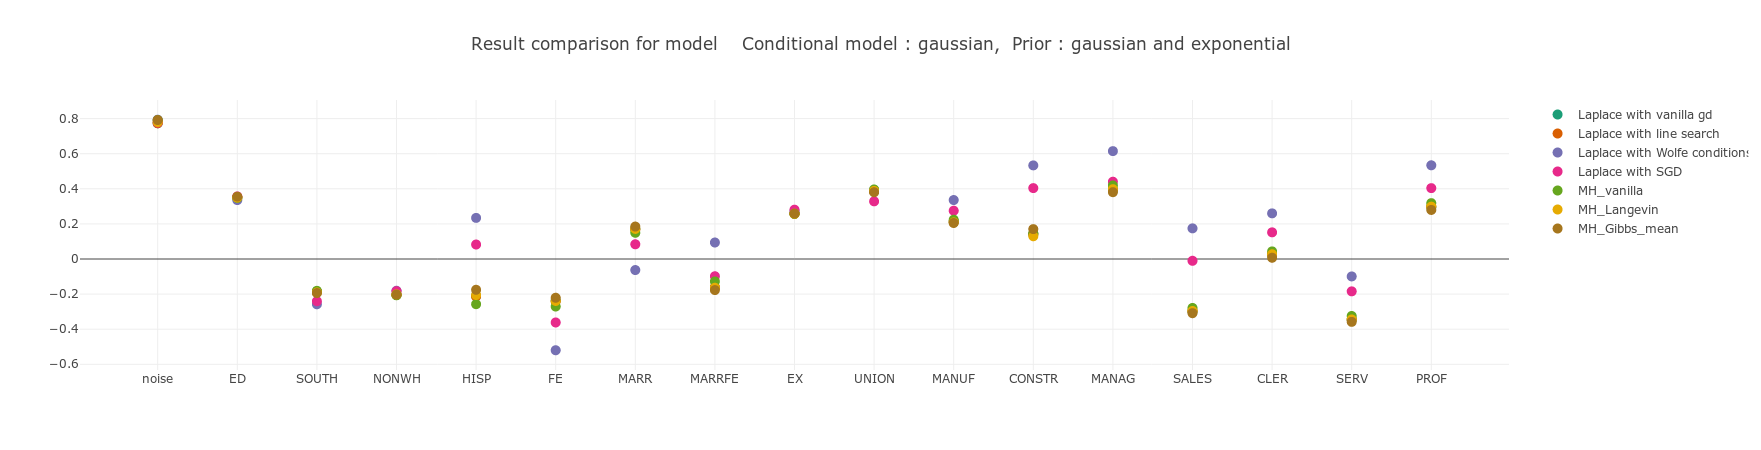

In [25]:
visualisation(r_gaussian,model_gaussian)

Some differences between the estimation of the parameters

Running Metropolis Hastings random walk from different starting point did not show any signs of multimodality, so one can assume this is just due to the variance in the optimization processes and the lack of time to really fine tune the hyperparameter for the Wolfe condition checkig gradient

Another possible explanation could be a plateau region in the optimization process

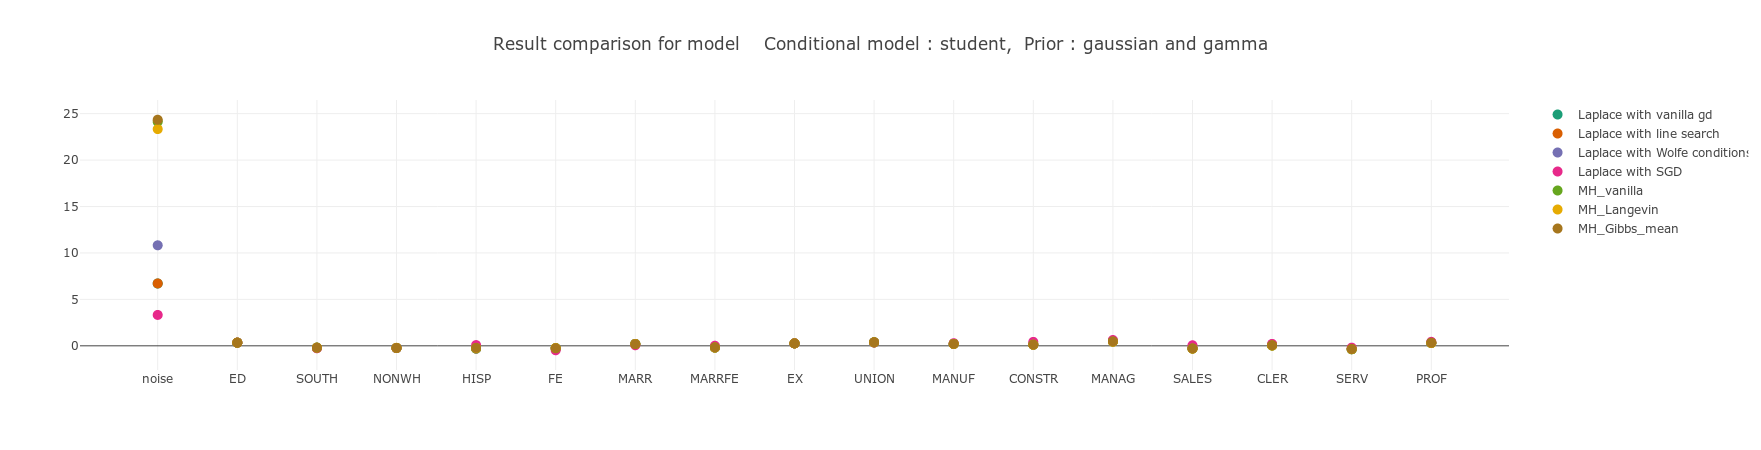

In [26]:
visualisation(r_student,model_student)

Same as below, and even if the difference in the df terms seems high, when we look at the predictive accuracy (see below) there are no signs for discrepancy. This leads to the conclusion that the width of the student distribution as a noise function does not have a lot of influence with this dataset.

From an optimization standpoint, this is probably due to the fact that since the degrees of freedom do not seem to influence that much the fit, there is a plateau region in the direction of the higher degrees of freedom that the optimization routines have trouble going trough

## Accuracy of the prediction

In order to predict, we have to use : $$ f(y| D = d) = \int f(y,\theta|D = d)d\theta = \int f(y|\theta)f(\theta|D=d)d\theta$$
Since we suppose our data are iid, the dependence of $y$ to $D$ is only through $\theta$



Supposing we want to approximate $y$ by its mean in the case of our first model, with the gaussian noise, gaussian prior on $\beta$ and exponential prior on $\sigma$:

\begin{align} \mathbb{E}[y|D=d] &= \int y f(y|D=d)dy \\
&= \int y \int f(y|\theta)f(\theta|D=d)d\theta dy \\
&= \int\int y f(y|\theta)f(\theta|D=d)d\theta dy\\
&= \int\left( \int y f(y|\theta)dy \right) f(\theta|D=d)d\theta \\
&= \int x^T\beta f(\theta|D=d)d\theta \\ 
&= \mathbb{E}_{\theta \sim \theta|D=d}[x^T\beta]\\
&= x^T \widehat{\beta}
\end{align}

So supposing we can switch the integrals (using Fubini since both functions are positive (densities) and the integral $\int y f(y|\theta)f(\theta|D=d)d\theta dy $ is finite ), the point prediction can be done by either marginalizing out the $\theta$, or by first finding the "optimal" theta and then predicting the mean of the conditional model. This is logic given that the marginalization of the $\theta$ is there because we do not know the distribution of the $\theta$, but only its distribution. But if we are interested in a point estimate, this inflation in the uncertainty of our precision is not directly usefull.


For our second model, the same development holds.

Otherwise we could just use the samples from the previous run of our Metropolis Hasting algorithms and for each $\theta$ sampled, compute a prediction $x^T\theta$ and then compute a statistic on these. 

When using the samples from Metropolis-Hastings algorithm, we will make a gaussian approximation of our posterior, so the MAP will be the mean or the median. Since this is an approximation, we will use both mean and median to see if there is any discrepancies in our reasonning.

In [27]:
errors_gaussian = pd.DataFrame()
for name in r_gaussian.columns:
    beta = r_gaussian[name].values[1:]
    errors_gaussian[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test),np.sum(np.abs(Y-np.dot(X,beta)))/len(Y)]
errors_gaussian.index = ["error on test","error on train"]
errors_gaussian.T

error on test  error on train
Laplace with vanilla gd             0.685788        0.613800
Laplace with line search            0.685607        0.613742
Laplace with Wolfe conditions       0.681076        0.627020
Laplace with SGD                    0.678958        0.620017
MH_vanilla                          0.684640        0.613416
MH_Langevin                         0.685191        0.613776
MH_Gibbs_mean                       0.687178        0.613785

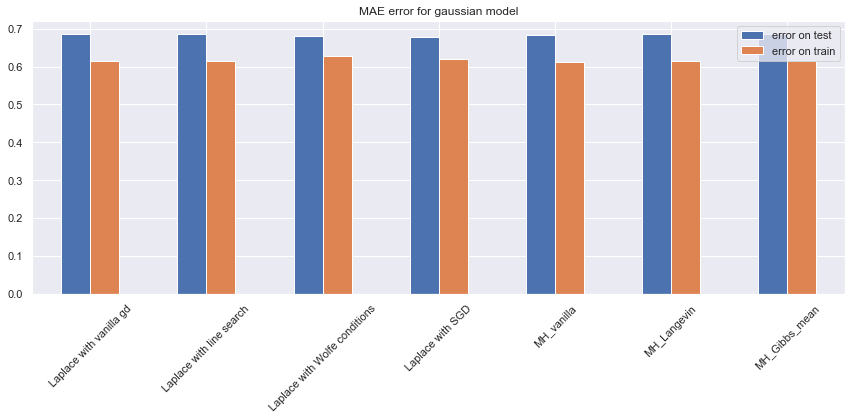

In [28]:
big_plot(12,6)
errors_gaussian.T.plot.bar()
plt.xticks(rotation= 45)
plt.title("MAE error for gaussian model")
plt.tight_layout()
plt.savefig("results/gaussian_accuracy.png", dpi = 300,bbox_inches = "tight")
reset_plot()

In [29]:
errors_student = pd.DataFrame()
for name in r_student.columns:
    beta = r_student[name].values[1:]
    errors_student[name] = [np.sum(np.abs(Y_test-np.dot(X_test,beta)))/len(Y_test),np.sum(np.abs(Y-np.dot(X,beta)))/len(Y)]
errors_student.index = ["error on test","error on train"]
errors_student.T

error on test  error on train
Laplace with vanilla gd             0.685289        0.609904
Laplace with line search            0.685292        0.609906
Laplace with Wolfe conditions       0.685170        0.610570
Laplace with SGD                    0.678832        0.615227
MH_vanilla                          0.687124        0.610595
MH_Langevin                         0.685432        0.611854
MH_Gibbs_mean                       0.683962        0.611568

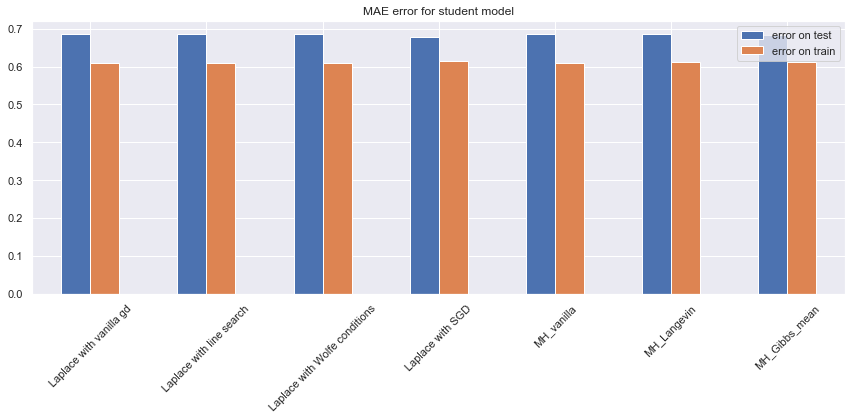

In [30]:
big_plot(12,6)
errors_student.T.plot.bar()
plt.xticks(rotation=45)
plt.title("MAE error for student model")
plt.tight_layout()
plt.savefig("results/student_accuracy.png", dpi = 300,bbox_inches = "tight")
reset_plot()

#### Marginalization of the $\theta$

Example of marginalization of the $\theta$ parameter and taking the MAP estimator on the posterior predictive density

We only do it for the gaussian model since it is quite heavy computationally speaking

In [31]:
from scipy.stats import norm as cheat_norm

In [32]:
samples_gaussian = [samples_gaussian_rw[1000:,], samples_gaussian_langevin[1000:,], samples_gaussian_gibbs[1000:,]]

In [33]:
y_grid = np.arange(-3,3.01,0.1)
scores = []
for S in samples_gaussian:
    y_pred = []
    for i,x_test in enumerate(X_test):
        #only taking the beta
        means = np.dot(S[:,1:],x_test)
        #exctraction of the sigma
        variances = S[:,1]
        s = S.shape[0]
        y_inter = np.repeat(y_grid,s, axis = 0)
        y_inter = y_inter.reshape(len(y_grid),s)
        density = np.mean(cheat_norm.pdf(y_inter, loc = means, scale = variances),axis = 1)
        y_pred.append(np.argmax(density))
    actual_prediction = [y_grid[p] for p in y_pred]
    scores.append(np.sum(np.abs(actual_prediction-Y_test))/len(Y_test))

In [34]:
scores

[0.6872834819701117, 0.6868828780063075, 0.6868828780063075]

This gives the same approximation as in the plots above, confirming our first method

# Classification 

`multilogi`:

- Conditional model
$$\mathbb{P}\left(Y=1|X\right) = \frac{e^{X^T\beta}}{1+e^{X^T\beta}}$$

- Prior:
$$\beta \sim N(0,3^2I) $$

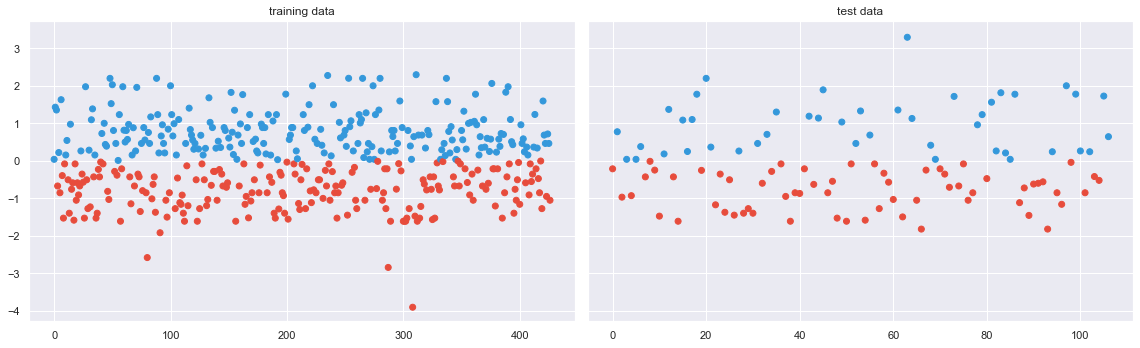

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

inter = Y
classes = inter.copy()
classes[Y >= 0] = 0
classes[Y < 0 ]= 1

#flatui = ["#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
flatui = ["#3498db", "#e74c3c", "#34495e", "#2ecc71"]

def convert(n): 
    return flatui[int(n)]
colors = list(map(convert, classes) )

axs[0].scatter(np.arange(0,X.shape[0]),Y, c = colors)
axs[0].set_title("training data")


inter = Y_test
classes_test = inter.copy()
classes_test[Y_test >= 0] = 0
classes_test[Y_test < 0 ]= 1
colors = list(map(convert, classes_test) )


axs[1].scatter(np.arange(0,X_test.shape[0]),Y_test, c = colors)
axs[1].set_title("test data")

plt.tight_layout()
plt.show()

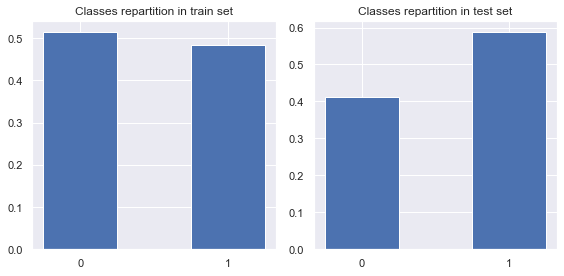

In [36]:
plt.subplot(121)
plt.bar([0.4,0.8],[len(classes[classes==0])/len(classes),len(classes[classes==1])/len(classes)],width = 0.2)
plt.xticks([0.4,0.8],[0,1])
plt.title("Classes repartition in train set")
plt.subplot(122)
plt.bar([0.4,0.8],[len(classes_test[classes_test==0])/len(classes_test),len(classes_test[classes_test==1])/len(classes_test)],width = 0.2)
plt.xticks([0.4,0.8],[0,1])
plt.title("Classes repartition in test set")
plt.tight_layout()
plt.show()

adding an intercept

In [37]:
X_intercept = np.append(X, np.ones((X.shape[0],1)), axis = 1)
X_intercept_test = np.append(X_test, np.ones((X_test.shape[0],1)), axis = 1)

In [38]:
multilogi = Model.Model(Prior.Gaussian_prior,Conditional_model.Multilogistic,data = X_intercept,response = classes, Prior = [0,3*np.ones(17)],cond_model = [2])

In [39]:
Laplace.laplace_approx(multilogi,method =  GD.vanilla_gd)

Progress : [====================] 100% Done...
   duration: 0:00:07


In [40]:
Laplace.laplace_approx(multilogi,method =  GD.line_search_gd,name_method="line search")

Progress : [====================] 100% Done...
   duration: 0:00:08


In [41]:
Laplace.laplace_approx(multilogi,method =  GD.Wolfe_cond_gd,name_method="Wolfe conditions")

Progress : [====================] 100% Done...
 early convergence at 4357 iterations  duration: 0:00:07


In [42]:
Laplace.laplace_approx(multilogi,method =  GD.stochastic_gd,name_method="SGD")

Progress : [====================] 100% Done...
 early convergence at 5069 iterations  duration: 0:00:05


Progress : [====================] 100% Done...
  Acceptance rate : 23.0%  (advised values between 10% and 50%)
  duration: 0:00:16
iterations


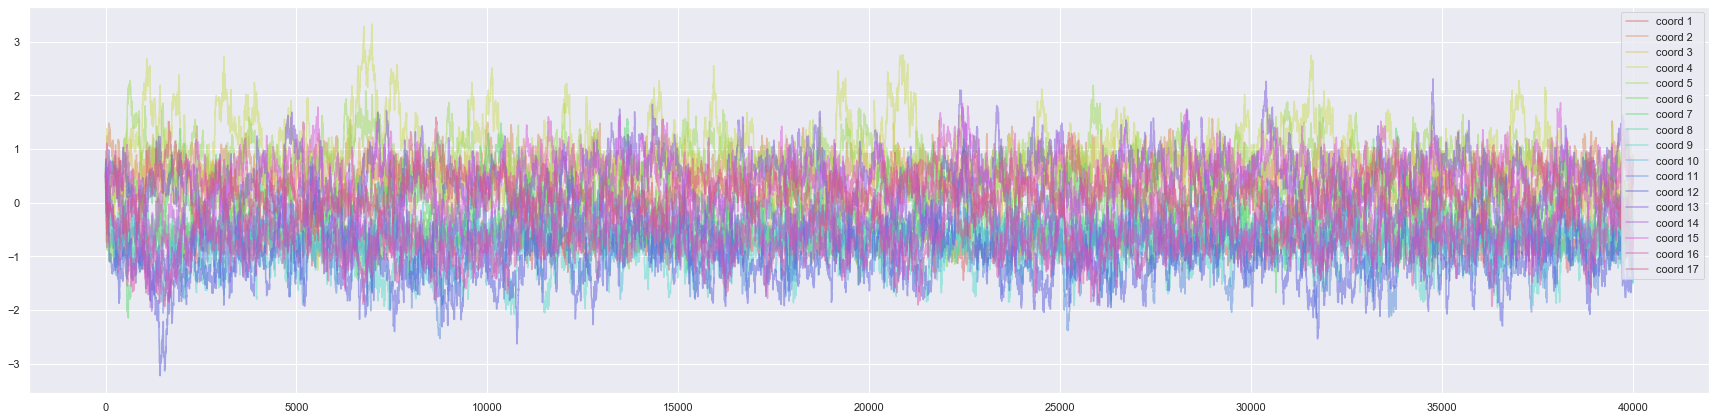

In [43]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.5
    samples_classification_rw = MH.random_walk_MH(multilogi, max_iter = 40000, verbose = True, step_size = 1.3*1e-1, initial = initial, RETURN=True)
    samples_exploration(samples_classification_rw, distribution=False, correlation= False)

Progress : [====================] 100% Done...
  Acceptance rate : 15.9%                 (advised values between 10% and 50%)
  duration: 0:01:01
iterations


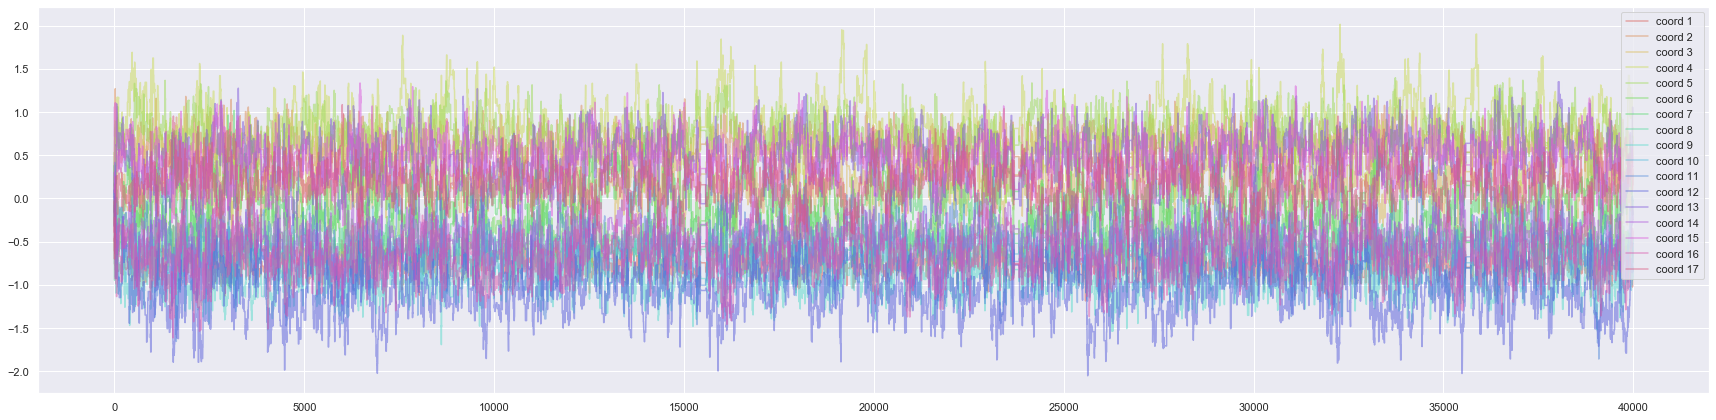

In [44]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.1
    samples_classification_langevin = MH.Langevin_MH(multilogi, max_iter = 40000, verbose = True, initial = initial, tau = 1e-2,RETURN=True)
    samples_exploration(samples_classification_langevin, distribution=False, correlation= False)

default batch is 5
Progress : [====================] 100% Done...
  Acceptance rate : 39.5%  (advised values between 10% and 50%)
  duration: 0:00:17
iterations


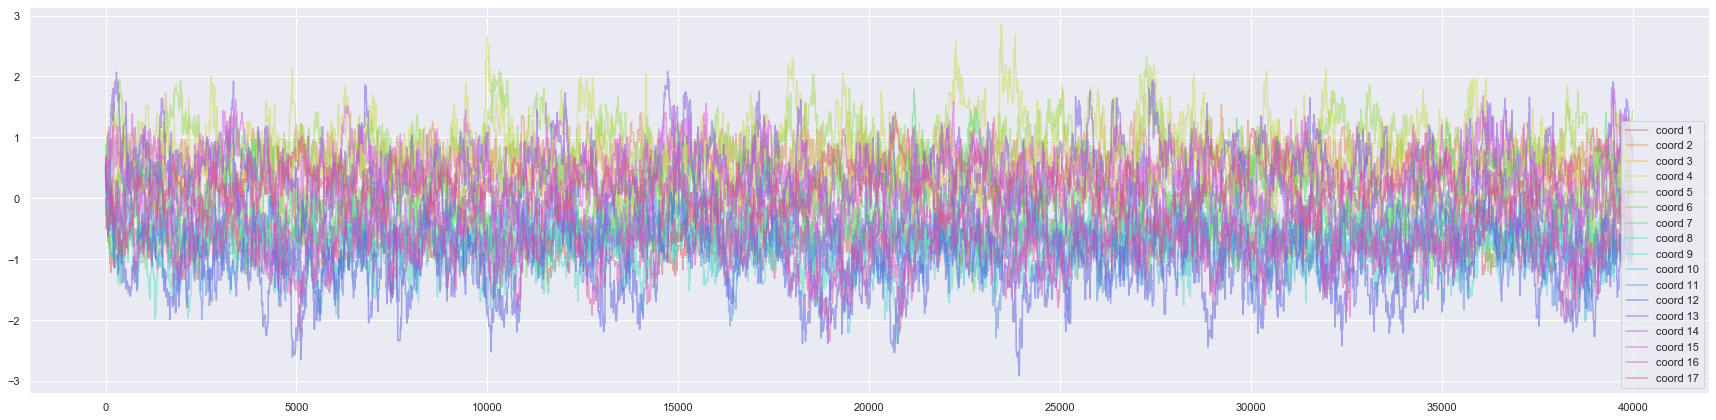

In [45]:
with warnings.catch_warnings(record = True):
    initial = np.zeros(multilogi.size) + 0.5
    samples_classification_gibbs = MH.MH_whithin_Gibbs(multilogi, max_iter = 40000, verbose = True, step_size = 2*1e-1, initial = initial, RETURN=True)
    samples_exploration(samples_classification_gibbs, distribution=False, correlation= False)

In [46]:
r_multilogi = multilogi()
r_multilogi.T

error         ED     SOUTH     NONWH  \
Laplace with vanilla gd       -0.748442  0.618206  0.202914  0.658488   
Laplace with line search      -0.738632  0.625371  0.118104  0.573111   
Laplace with Wolfe conditions -0.729277  0.615070  0.172639  0.725618   
Laplace with SGD              -0.611659  0.549857  0.366705  0.649774   
MH_vanilla                    -0.761591  0.643059  0.179359  0.843646   
MH_Langevin                   -0.745563  0.624065  0.179244  0.758960   
MH_Gibbs_mean                 -0.759827  0.643955  0.216271  0.788822   

                                   HISP        FE      MARR    MARRFE  \
Laplace with vanilla gd        0.859585 -0.232418 -0.245795 -0.567652   
Laplace with line search       0.415592 -0.542851  0.298598 -0.537277   
Laplace with Wolfe conditions  0.667830 -0.373298  0.002855 -0.545639   
Laplace with SGD               0.193343 -0.514467  0.265000 -0.472259   
MH_vanilla                     0.686159 -0.370447 -0.021334 -0.575951   
MH_Langevin                    0.693999 -0.384963 -0.008095 -0.555239   
MH_Gibbs_mean                  0.768052 -0.353836 -0.055355 -0.574225   

                                     EX     UNION     MANUF    CONSTR  \
Laplace with vanilla gd       -0.895487 -0.682043 -0.538838 -0.981948   
Laplace with line search      -0.885531 -0.681941 -0.558348 -0.978303   
Laplace with Wolfe conditions -0.904378 -0.705753 -0.553115 -1.055339   
Laplace with SGD              -0.510071 -0.131482  0.228352 -0.217513   
MH_vanilla                    -0.953542 -0.711380 -0.555744 -1.083166   
MH_Langevin                   -0.918794 -0.709518 -0.567536 -1.082291   
MH_Gibbs_mean                 -0.929387 -0.752895 -0.603613 -1.149664   

                                  MANAG     SALES      CLER      SERV  \
Laplace with vanilla gd        0.475265 -0.382326  0.474888 -0.610989   
Laplace with line search       0.498661 -0.366231  0.498874 -0.551701   
Laplace with Wolfe conditions  0.429124 -0.431663  0.433063 -0.649490   
Laplace with SGD               0.509285  0.255209  0.896059 -0.291216   
MH_vanilla                     0.489588 -0.413832  0.487977 -0.662199   
MH_Langevin                    0.455583 -0.444804  0.441710 -0.662288   
MH_Gibbs_mean                  0.424223 -0.501088  0.382549 -0.747061   

                                   PROF  
Laplace with vanilla gd        0.030571  
Laplace with line search       0.269463  
Laplace with Wolfe conditions  0.180688  
Laplace with SGD              -0.156792  
MH_vanilla                     0.162381  
MH_Langevin                    0.181063  
MH_Gibbs_mean                  0.182042

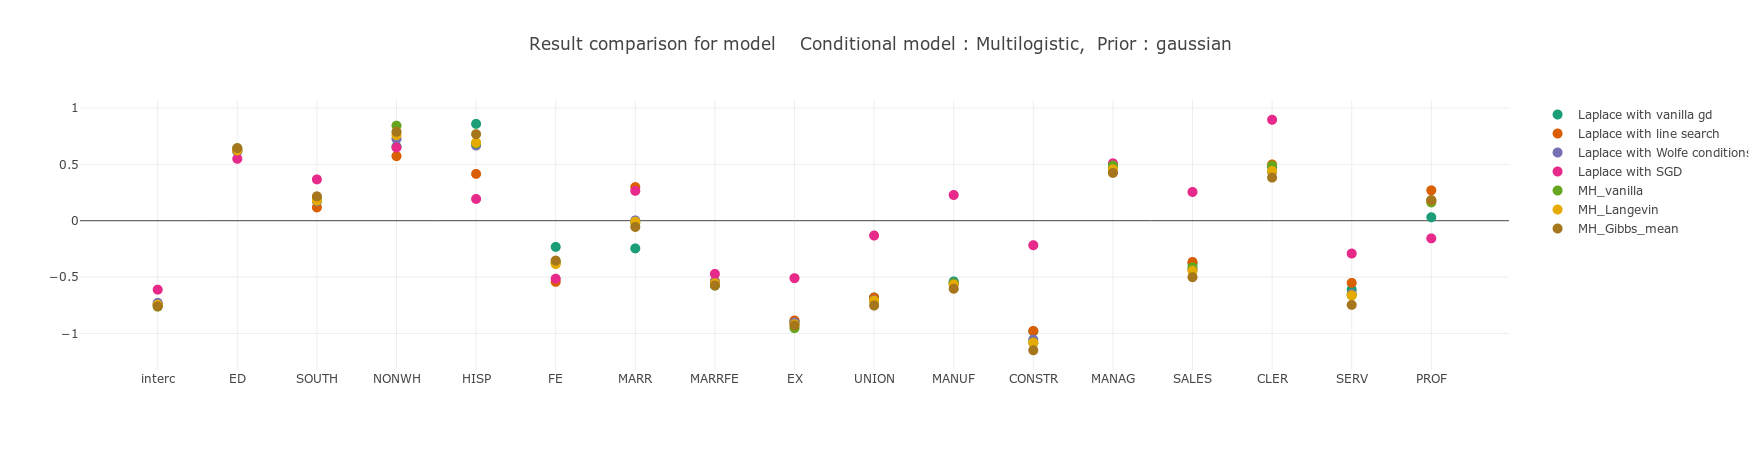

In [47]:
visualisation(r_multilogi,multilogi)

## Results of logistic regression

In order to predict, we will minimize the misclassification error, which mean we will use the decision boundary $\mathbb{P}[Y=1|x]>=0.5$.

Following Bishop _Pattern recognition and Machine learning_, p.220, we first compute the MAP of our parameter $\beta$, and then use it to predict our classes using the decisin boundary above.

In [48]:
predictions = multilogi.predict(X_intercept_test)
fitted = multilogi.predict(X_intercept)

In [49]:
errors = {}

In [50]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes_test):
        if pred != true:
            error+=1    
    if name in errors.keys():
        errors[name].append(error/len(classes_test))
    else:
        errors[name] = [error/len(classes_test)]

In [51]:
for name in predictions.columns:
    error = 0
    for pred,true in zip(predictions[name],classes):
        if pred != true:
            error+=1    
    if name in errors.keys():
        errors[name].append(error/len(classes))
    else:
        errors[name] = [error/len(classes)]

In [52]:
errors = pd.DataFrame(errors)
errors.index = ["error on test", "error on train"]
errors.T

error on test  error on train
Laplace with vanilla gd             0.261682        0.117096
Laplace with line search            0.280374        0.121780
Laplace with Wolfe conditions       0.280374        0.121780
Laplace with SGD                    0.280374        0.121780
MH_vanilla                          0.280374        0.121780
MH_Langevin                         0.280374        0.121780
MH_Gibbs_mean                       0.280374        0.121780

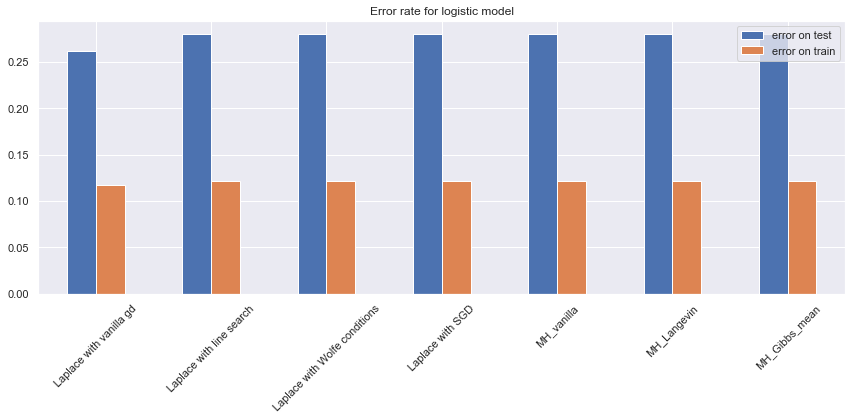

In [53]:
big_plot(12,6)
errors.T.plot.bar()
plt.xticks(rotation=45)
plt.title("Error rate for logistic model")
plt.tight_layout()
plt.savefig("results/logistic_accuracy.png", dpi = 300,bbox_inches = "tight")
reset_plot()

In [54]:
# by simulation using the samples above:
samples = [samples_classification_gibbs[1000:,],samples_classification_langevin[1000:,],samples_classification_rw[1000:,]]
names = ["gibbs","langevn","vanilla MH"]

df_result_sampled = {}


def link(x,theta):
    return np.dot(x,theta)

for i,S in enumerate(samples):
    error_rate = 0
    for x,y in zip(X_intercept_test,classes_test):
        expo = link(x,S.T)
        proba = np.exp(expo)/(1+np.exp(expo))
        if np.sum(proba >=0.5)>np.sum(proba < 0.5):
            predict = 1
        else:
            predict = 0
        if predict != y:
            error_rate +=1 
    if i == 0:
        df_result_sampled["test"] = [error_rate/len(classes_test)]
    else:
         df_result_sampled["test"].append(error_rate/len(classes_test))

In [55]:
df_result_sampled

{'test': [0.2803738317757009, 0.2803738317757009, 0.27102803738317754]}

So both gives the same results, but the first one is quicker 

# Comparison of time efficiency of the methods

In [56]:
models = [model_gaussian,model_student,multilogi]

In [57]:
dic_time = {}
dic_time_per_iter = {}
for m in models:
    for key,elt in m.time.items():
        if key in dic_time:
            dic_time[key].append(elt[0])
            dic_time_per_iter[key].append(elt[0]/elt[1])
        else:
            dic_time[key]=[elt[0]]
            dic_time_per_iter[key]=[elt[0]/elt[1]]


In [58]:
df_time = pd.DataFrame(dic_time)
df_time_per_iter = pd.DataFrame(dic_time_per_iter)
df_time.index = ["gaussian","student","logistic"]
df_time_per_iter.index = ["gaussian","student","logistic"]

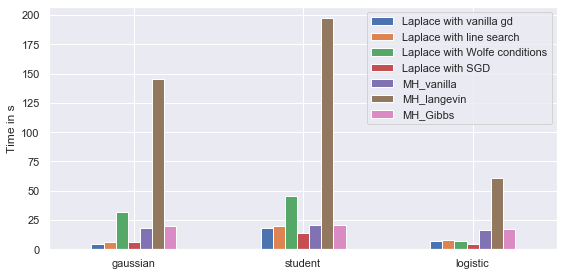

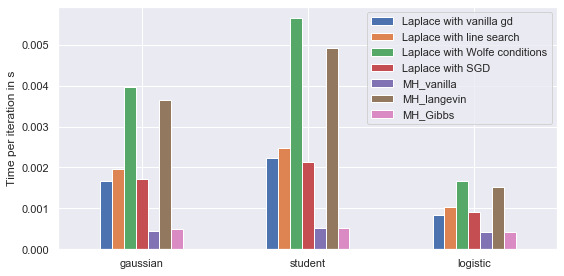

In [59]:
df_time.plot.bar()
plt.xticks(rotation="horizontal")
plt.ylabel("Time in s")
plt.tight_layout()
plt.savefig("results/time.png", dpi = 300,bbox_inches = "tight")
df_time_per_iter.plot.bar()
plt.xticks(rotation="horizontal")
plt.ylabel("Time per iteration in s")
plt.tight_layout()
plt.savefig("results/time_per_iter.png", dpi = 300,bbox_inches = "tight")